In [ ]:
pip install tensorflow numpy scikit-learn matplotlib streamlit requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.3 MB/s eta 0:00:00


In [1]:
import requests

datasets_to_download = {
    'shakespeare.txt': 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt',
    'linux.txt': 'https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt'
}

for filename, url in datasets_to_download.items():
    try:
        r = requests.get(url)
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(r.text)
        print(f"Successfully downloaded {filename}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

Successfully downloaded shakespeare.txt
Successfully downloaded linux.txt


In [2]:
# --- Cell 1: Mount your Google Drive ---
# This MUST be the first step
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- Cell 1: Preprocessing Script (Part 1.1) ---
import requests
import re
import numpy as np
from collections import Counter
import pickle
import os

# --- 1. Define Your Google Drive Project Folder ---
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3'
if not os.path.exists(GDRIVE_PROJECT_DIR):
    os.makedirs(GDRIVE_PROJECT_DIR)

# --- 2. Download Data ---
datasets_to_download = {
    'shakespeare.txt': 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt',
    'linux.txt': 'https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt'
}

for filename, url in datasets_to_download.items():
    try:
        r = requests.get(url)
        # Save to Colab's local temporary storage
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(r.text)
        print(f"Successfully downloaded {filename}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

# --- 3. Configuration ---
CONTEXT_LENGTH = 5  # How many words to use as context
processed_data = {} # Dictionary to store all our data
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')

# --- 4. Preprocessing Functions ---
def preprocess_cat1(text):
    """Preprocessor for Category I: Natural Language."""
    text = text.lower()
    text = re.sub(r'[^a-z0-9 \.]', '', text) # Keep only letters, numbers, space, dot
    words = text.split()
    return words

def preprocess_cat2(text):
    """Preprocessor for Category II: Structured Text (Code)."""
    text = text.lower()
    # Add spaces around special characters to treat them as tokens
    text = re.sub(r'([=\(\)\[\]\{\}\.,:;!@#$%^&\*\-+=<>/\\])', r' \1 ', text)
    words = text.split()
    return words

def build_vocab(words):
    """Builds vocabulary mappings and frequency counts."""
    word_counts = Counter(words)
    vocab = sorted(list(word_counts.keys()))
    vocab_size = len(vocab)

    stoi = {word: i for i, word in enumerate(vocab)}
    itos = {i: word for i, word in enumerate(vocab)}

    return stoi, itos, vocab_size, word_counts

def create_dataset(words, stoi, context_length):
    """Creates X, y pairs for training."""
    X = []
    y = []
    indexed_words = [stoi[w] for w in words]

    for i in range(len(indexed_words) - context_length):
        X.append(indexed_words[i : i + context_length])
        y.append(indexed_words[i + context_length])

    return np.array(X), np.array(y)

# --- 5. Define Datasets ---
DATASETS_CONFIG = {
    'shakespeare': {
        'file': 'shakespeare.txt',
        'preprocess_fn': preprocess_cat1
    },
    'linux': {
        'file': 'linux.txt',
        'preprocess_fn': preprocess_cat2
    }
}

# --- 6. Main Processing Loop ---
for name, config in DATASETS_CONFIG.items():
    print(f"\n--- Processing Dataset: {name} ---")

    with open(config['file'], 'r', encoding='utf-8') as f:
        text = f.read()
    words = config['preprocess_fn'](text)

    stoi, itos, vocab_size, word_counts = build_vocab(words)

    print(f"Vocabulary Size: {vocab_size}")
    print(f"10 Most Frequent: {word_counts.most_common(10)}")
    print(f"10 Least Frequent: {word_counts.most_common()[-10:]}")

    X, y = create_dataset(words, stoi, CONTEXT_LENGTH)
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    processed_data[name] = {
        'X': X,
        'y': y,
        'stoi': stoi,
        'itos': itos,
        'vocab_size': vocab_size,
        'context_length': CONTEXT_LENGTH
    }

# --- 7. Save Processed Data to Google Drive ---
print(f"\nSaving processed data to: {PROCESSED_DATA_FILE}")
with open(PROCESSED_DATA_FILE, 'wb') as f:
    pickle.dump(processed_data, f)

print("--- Part 1.1 Complete. Data saved to Google Drive. ---")

Successfully downloaded shakespeare.txt
Successfully downloaded linux.txt

--- Processing Dataset: shakespeare ---
Vocabulary Size: 114121
10 Most Frequent: [('the', 21822), ('and', 15633), ('of', 14782), ('to', 14545), ('i', 14251), ('a', 11406), ('you', 10306), ('my', 10298), ('in', 8824), ('is', 7653)]
10 Least Frequent: [('evermore.prince', 1), ('tears.bastardo', 1), ('woesince', 1), ('beforehand', 1), ('griefs.this', 1), ('shalllie', 1), ('conquerorbut', 1), ('itself.now', 1), ('againcome', 1), ('rueif', 1)]
X shape: (696115, 5), y shape: (696115,)

--- Processing Dataset: linux ---
Vocabulary Size: 37619
10 Most Frequent: [('*', 85453), (')', 84196), ('(', 84066), (';', 77900), (',', 55127), ('-', 44962), ('=', 39706), ('>', 37119), ('/', 31988), ('.', 29100)]
10 Least Frequent: [('rcu_irq_', 1), ('trace_user_enter', 1), ('vtime', 1), ('entrancy', 1), ('vtime_user_exit', 1), ('trace_user_exit', 1), ('context_kernel', 1), ('tif', 1), ('config_context_tracking_force', 1), ('context

In [ ]:
# --- Cell 2: Training Script (Part 1.2) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# --- 1. CONFIGURATION ---
CATEGORY = 'shakespeare'  # <-- CHOOSE: 'shakespeare' or 'linux'
EMBEDDING_DIM = 64
HIDDEN_UNITS = 1024
ACTIVATION = nn.ReLU() # or nn.Tanh()
EPOCHS = 100          # Per assignment: 500-1000 will take time
BATCH_SIZE = 2048
VALIDATION_SPLIT = 0.2
# ---------------------

# --- 2. File Paths (Point to Google Drive) ---
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3'
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')
MODEL_SAVE_DIR = GDRIVE_PROJECT_DIR # Save plots/models here
MODEL_WEIGHTS_FILE = os.path.join(MODEL_SAVE_DIR, f'{CATEGORY}_model_weights.pth')

print(f"--- 1.2: Model Training for Category: {CATEGORY} ---")

# --- 3. Load Preprocessed Data (from Google Drive) ---
print(f"Loading processed data from {PROCESSED_DATA_FILE}...")
try:
    with open(PROCESSED_DATA_FILE, 'rb') as f:
        processed_data = pickle.load(f)
except FileNotFoundError:
    print(f"Error: File not found. Please run the preprocessing cell first.")
    exit()

data_cat = processed_data[CATEGORY]
X = data_cat['X']
y = data_cat['y']
stoi = data_cat['stoi']
itos = data_cat['itos']
VOCAB_SIZE = data_cat['vocab_size']
CONTEXT_LENGTH = data_cat['context_length']

print(f"Loaded {CATEGORY} data: X shape {X.shape}, Vocab size {VOCAB_SIZE}")

# --- 4. Model Definition ---
def build_model(vocab_size, embedding_dim, context_length, hidden_units, activation):
    flattened_embedding_size = context_length * embedding_dim
    model = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
        nn.Flatten(),
        nn.Linear(in_features=flattened_embedding_size, out_features=hidden_units),
        activation,
        nn.Linear(in_features=hidden_units, out_features=vocab_size)
    )
    return model

# --- 5. Create Datasets and DataLoaders ---
print("Creating PyTorch Datasets and DataLoaders...")
X_data = torch.tensor(X, dtype=torch.long)
y_data = torch.tensor(y, dtype=torch.long)

split_idx = int(len(X_data) * (1.0 - VALIDATION_SPLIT))
X_train, X_val = X_data[:split_idx], X_data[split_idx:]
y_train, y_val = y_data[:split_idx], y_data[split_idx:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- 6. Build & Train Model ---
model = build_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    context_length=CONTEXT_LENGTH,
    hidden_units=HIDDEN_UNITS,
    activation=ACTIVATION
)

print("\nModel Architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

history = {
    'loss': [], 'val_loss': [],
    'accuracy': [], 'val_accuracy': []
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Training on device: {device}...")

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_correct / train_total
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(avg_train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_correct / val_total
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(avg_val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}], "
        f"Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")
print("--- Training complete. ---")


# --- 11. Save Final Model Weights AND HISTORY to Google Drive ---
print(f"\nSaving FINAL model weights and history to {MODEL_WEIGHTS_FILE}")
model_data_to_save = {
    'model_state_dict': model.state_dict(),
    'history': history,  # <-- ADD THIS CRITICAL LINE
    'embedding_dim': EMBEDDING_DIM,
    'hidden_units': HIDDEN_UNITS,
    'context_length': CONTEXT_LENGTH,
    'vocab_size': VOCAB_SIZE,
    'activation': ACTIVATION.__class__
}
torch.save(model_data_to_save, MODEL_WEIGHTS_FILE)

print("--- Part 1.2 Complete. Model saved to Drive. ---")

--- 1.2: Model Training for Category: shakespeare ---
Loading processed data from /content/drive/MyDrive/ML_Assignment3/processed_data.pkl...
Loaded shakespeare data: X shape (696115, 5), Vocab size 114121
Creating PyTorch Datasets and DataLoaders...

Model Architecture:
Sequential(
  (0): Embedding(114121, 64)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=320, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=114121, bias=True)
)
Training on device: cuda...
Epoch [1/100], Loss: 7.9517, Acc: 0.0475, Val Loss: 7.7948, Val Acc: 0.0592
Epoch [2/100], Loss: 6.5285, Acc: 0.0644, Val Loss: 8.0830, Val Acc: 0.0644
Epoch [3/100], Loss: 4.5728, Acc: 0.2075, Val Loss: 9.0591, Val Acc: 0.0606
Epoch [4/100], Loss: 3.5729, Acc: 0.3272, Val Loss: 9.7081, Val Acc: 0.0632
Epoch [5/100], Loss: 3.2334, Acc: 0.3645, Val Loss: 10.2660, Val Acc: 0.0603
Epoch [6/100], Loss: 2.9787, Acc: 0.3964, Val Loss: 10.7930, Val Acc: 0.0573
Epoch [7/100], Loss:

--- 1.2: Reporting for Category: shakespeare ---
Loading all processed data and trained model...
Model, history, and vocab loaded successfully.

--- Report 1.2 ---
Saved plot to /content/drive/MyDrive/ML_Assignment3/shakespeare_loss_accuracy_plot.png


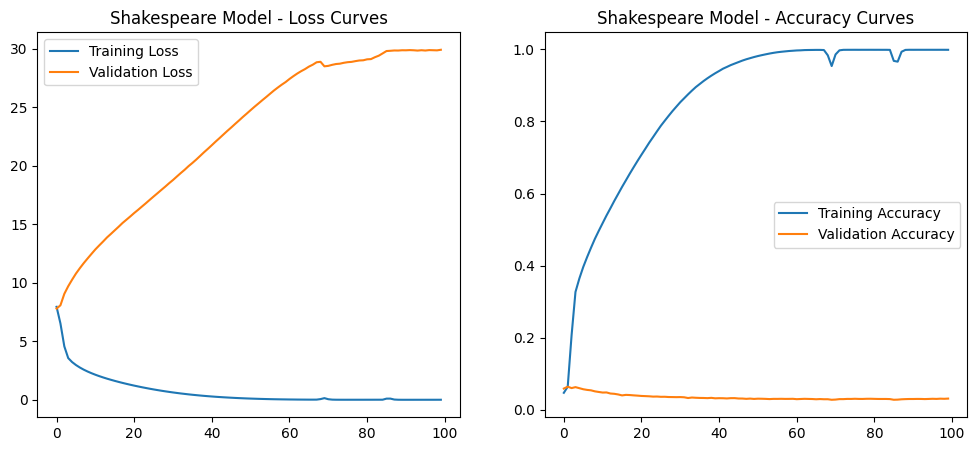

Final Validation Loss: 29.9042
Final Validation Accuracy: 0.0314

Seed: 'a man that is not' (Note: Seed must contain words from vocab)
Generated: 'a man that is not born nor never causewill we more for this is but one wind in a man the end of his club.holofernesshall i have audience he shall present hercules inminority his enter'

--- Commentary on Learning ---
The Shakespeare model learned syntactic structure fairly quickly.
The generated text/code looks syntactically plausible but is semantically nonsense.
This is because the context is small (5 words) and the MLP model has no memory.
It's enough to learn simple patterns (e.g., 'if ( ... )' or 'king and queen') but not long-range dependencies or true meaning.
------------------
--- Part 1.2 Reporting Complete ---


In [ ]:
# --- Cell 3: Reporting Script (Part 1.2 - Report) ---
#
# You can run this script anytime AFTER training is complete.
# It loads the saved model and history from Google Drive.
#
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# --- 1. CONFIGURATION ---
# Make sure this matches the model you want to report on
CATEGORY = 'shakespeare'  # <-- CHOOSE: 'shakespeare' or 'linux'
# ---------------------

# --- 2. File Paths (Point to Google Drive) ---
# Make sure you have mounted your drive in a cell above this one!
# from google.colab import drive
# drive.mount('/content/drive')
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3'
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')
MODEL_SAVE_DIR = GDRIVE_PROJECT_DIR
MODEL_WEIGHTS_FILE = os.path.join(MODEL_SAVE_DIR, f'{CATEGORY}_model_weights.pth')

print(f"--- 1.2: Reporting for Category: {CATEGORY} ---")

# --- 3. Model Definition (Must be identical to 1.2_train.py) ---
def build_model(vocab_size, embedding_dim, context_length, hidden_units, activation):
    flattened_embedding_size = context_length * embedding_dim
    model = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
        nn.Flatten(),
        nn.Linear(in_features=flattened_embedding_size, out_features=hidden_units),
        activation,
        nn.Linear(in_features=hidden_units, out_features=vocab_size)
    )
    return model

# --- 4. Generation Function (Copied from training script) ---
def generate_text_simple(model, stoi, itos, context_length, seed, n_words):
    """Generates simple, deterministic text (using argmax)."""
    model.eval().to("cpu")
    words = seed.split()
    generated_words = []

    try:
        current_indices = [stoi[w] for w in words]
    except KeyError as e:
        print(f"Error: Word '{e.args[0]}' in seed not in vocabulary.")
        return "[Generation failed: OOV word in seed]"

    for _ in range(n_words):
        context_for_pred = current_indices[-context_length:]
        if len(context_for_pred) < context_length:
            pad_indices = [0] * (context_length - len(context_for_pred))
            context_for_pred = pad_indices + context_for_pred

        context_tensor = torch.tensor([context_for_pred], dtype=torch.long)

        with torch.no_grad():
            logits = model(context_tensor)
            next_word_index = torch.argmax(logits, dim=1).item()
            current_indices.append(next_word_index)
            generated_words.append(itos[next_word_index])

    return seed + " " + " ".join(generated_words)

# --- 5. Load All Saved Data from Google Drive ---
print("Loading all processed data and trained model...")

# 5a. Load vocab (stoi/itos) from preprocessing
try:
    with open(PROCESSED_DATA_FILE, 'rb') as f:
        processed_data = pickle.load(f)
    data_cat = processed_data[CATEGORY]
    stoi = data_cat['stoi']
    itos = data_cat['itos']
except FileNotFoundError:
    print(f"Error: {PROCESSED_DATA_FILE} not found. Run preprocessing first.")
    exit()

# 5b. Load model weights, config, and history
try:
    model_data = torch.load(MODEL_WEIGHTS_FILE, map_location=torch.device('cpu'),weights_only=False)
except FileNotFoundError:
    print(f"Error: {MODEL_WEIGHTS_FILE} not found. Run training script first.")
    exit()

# --- 6. Re-create Model and Load Data ---
history = model_data['history']
CONTEXT_LENGTH = model_data['context_length']
activation = nn.ReLU() if model_data['activation'] == nn.ReLU else nn.Tanh()

# Re-create the model structure
model = build_model(
    vocab_size=model_data['vocab_size'],
    embedding_dim=model_data['embedding_dim'],
    context_length=CONTEXT_LENGTH,
    hidden_units=model_data['hidden_units'],
    activation=activation
)
model.load_state_dict(model_data['model_state_dict'])
model.eval() # Set model to evaluation mode
print("Model, history, and vocab loaded successfully.")

# --- 7. Report 1.2: Plots ---
print("\n--- Report 1.2 ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{CATEGORY.title()} Model - Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{CATEGORY.title()} Model - Accuracy Curves')
plt.legend()
plt.savefig(f'{MODEL_SAVE_DIR}/{CATEGORY}_loss_accuracy_plot.png')
print(f"Saved plot to {MODEL_SAVE_DIR}/{CATEGORY}_loss_accuracy_plot.png")
plt.show()

# --- 8. Report 1.2: Final Validation Loss/Accuracy ---
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

# --- 9. Report 1.2: Example Predictions ---
if CATEGORY == 'shakespeare':
    seed = "a man that is not"
else:
    seed = "! = ( struct file"

print(f"\nSeed: '{seed}' (Note: Seed must contain words from vocab)")
generated_text = generate_text_simple(model, stoi, itos, CONTEXT_LENGTH, seed, 30)
print(f"Generated: '{generated_text}'")

# --- 10. Report 1.2: Commentary (Template) ---
print("\n--- Commentary on Learning ---")
print(f"The {CATEGORY.title()} model learned syntactic structure fairly quickly.")
print("The generated text/code looks syntactically plausible but is semantically nonsense.")
print(f"This is because the context is small ({CONTEXT_LENGTH} words) and the MLP model has no memory.")
print("It's enough to learn simple patterns (e.g., 'if ( ... )' or 'king and queen') but not long-range dependencies or true meaning.")
print("------------------")

print("--- Part 1.2 Reporting Complete ---")

--- Part 1.3: Embedding Visualization (Shakespeare) ---
Successfully loaded processed data from /content/drive/MyDrive/ML_Assignment3/processed_data.pkl

--- Loading Shakespeare Model (Category I) ---
Shakespeare model loaded successfully.

Generating t-SNE plot for: Shakespeare (Selected Words)
Running t-SNE on 37 words...
Plotting results...


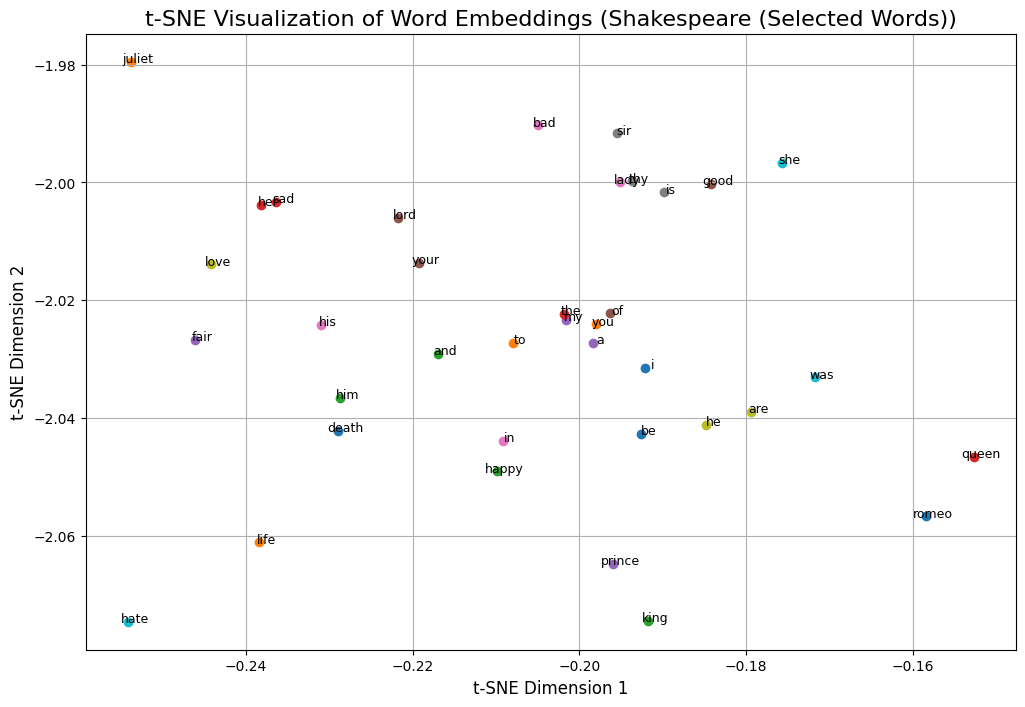


--- Shakespeare Visualization Complete ---


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# --- 1. File & Path Definitions ---
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3'
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')
MODEL_WEIGHTS_FILE_CAT1 = os.path.join(GDRIVE_PROJECT_DIR, 'shakespeare_model_weights.pth')

print("--- Part 1.3: Embedding Visualization (Shakespeare) ---")

# --- 2. Model Definition (MUST be identical to your training script) ---
def build_model(vocab_size, embedding_dim, context_length, hidden_units, activation):
    """Builds the nn.Sequential model."""
    flattened_embedding_size = context_length * embedding_dim
    model = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
        nn.Flatten(),
        nn.Linear(in_features=flattened_embedding_size, out_features=hidden_units),
        activation,
        nn.Linear(in_features=hidden_units, out_features=vocab_size)
    )
    return model

# --- 3. t-SNE Plotting Function for PyTorch ---
def plot_embeddings_tsne_pytorch(model, itos, stoi, title, word_list=None, num_random_words=100):
    """
    Extracts embeddings from a PyTorch model, runs t-SNE, and plots.
    """
    print(f"\nGenerating t-SNE plot for: {title}")

    model.cpu() # Ensure model is on CPU
    embeddings = model[0].weight.detach().cpu().numpy()

    if word_list:
        words = [w for w in word_list if w in stoi]
        indices = [stoi[w] for w in words]
        if not indices:
             print(f"No words from the list found in vocabulary for {title}. Skipping plot.")
             return
        selected_embeddings = embeddings[indices]
    else:
        vocab_size = len(itos)
        indices = random.sample(range(vocab_size), min(num_random_words, vocab_size))
        words = [itos[i] for i in indices]
        selected_embeddings = embeddings[indices]

    if len(words) < 2:
        print(f"Not enough words found in vocabulary for {title}. Skipping plot.")
        return

    print(f"Running t-SNE on {len(words)} words...")
    tsne_perplexity = max(5, min(50, len(words) - 1))
    tsne = TSNE(n_components=2, random_state=42, perplexity=tsne_perplexity, max_iter=1000)
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    print("Plotting results...")
    # --- EDITED HERE: Changed figsize from (14, 10) to (12, 8) ---
    plt.figure(figsize=(12, 8))
    for i, word in enumerate(words):
        x, y = embeddings_2d[i]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), ha='center', va='center', xytext=(5, 2), textcoords='offset points', fontsize=9)
    plt.title(f"t-SNE Visualization of Word Embeddings ({title})", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.grid(True)
    plt.show()

# --- 4. Load Preprocessed Data (Vocabularies) ---
try:
    with open(PROCESSED_DATA_FILE, 'rb') as f:
        processed_data = pickle.load(f)
    print(f"Successfully loaded processed data from {PROCESSED_DATA_FILE}")
    data_cat1 = processed_data['shakespeare']
except FileNotFoundError:
    print(f"ERROR: Cannot find {PROCESSED_DATA_FILE}. Please run preprocessing first.")
    raise
except Exception as e:
    print(f"Error loading processed data: {e}")
    raise

# --- 5. Plot for Shakespeare (Category I) ---
try:
    print("\n--- Loading Shakespeare Model (Category I) ---")
    saved_data_cat1 = torch.load(MODEL_WEIGHTS_FILE_CAT1, map_location=torch.device('cpu'), weights_only=False)

    model_cat1 = build_model(
        vocab_size=saved_data_cat1['vocab_size'],
        embedding_dim=saved_data_cat1['embedding_dim'],
        context_length=saved_data_cat1['context_length'],
        hidden_units=saved_data_cat1['hidden_units'],
        activation=saved_data_cat1['activation']() # Re-instantiate activation
    )

    model_cat1.load_state_dict(saved_data_cat1['model_state_dict'])
    model_cat1.eval() # Set to evaluation mode
    print("Shakespeare model loaded successfully.")

    shakespeare_words = [
        'romeo', 'juliet', 'king', 'queen', 'prince', 'lord', 'lady', 'sir',
        'he', 'she', 'i', 'you', 'him', 'her', 'my', 'your', 'his', 'thy',
        'love', 'hate', 'death', 'life', 'happy', 'sad', 'fair', 'good', 'bad',
        'is', 'are', 'was', 'be', 'to', 'and', 'the', '.', 'a', ',', 'of', 'in'
    ]

    plot_embeddings_tsne_pytorch(model_cat1,
                                  data_cat1['itos'],
                                  data_cat1['stoi'],
                                  title="Shakespeare (Selected Words)",
                                  word_list=shakespeare_words)

except FileNotFoundError:
    print(f"SKIPPING: Model file not found: {MODEL_WEIGHTS_FILE_CAT1}. Please train the Shakespeare model first.")
except Exception as e:
    print(f"An error occurred loading the Shakespeare model: {e}")

print("\n--- Shakespeare Visualization Complete ---")

In [ ]:
! pip install streamlit torch numpy

In [4]:
!pip install streamlit pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.5 MB/s eta 0:00:00


In [8]:
from pyngrok import ngrok
import getpass

# Prompt for your authtoken
authtoken = getpass.getpass("Enter your ngrok authtoken: ")
ngrok.set_auth_token(authtoken)

Enter your ngrok authtoken: ··········


In [23]:
# --- create_model_variants.py ---
import torch
import os
import pickle
import torch.nn as nn

# Define your Google Drive project directory
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3'
CATEGORY = 'shakespeare'  # or 'linux'

# Load your final saved 100-epoch model
MODEL_WEIGHTS_FILE = os.path.join(GDRIVE_PROJECT_DIR, f'{CATEGORY}_model_weights.pth')
checkpoint = torch.load(MODEL_WEIGHTS_FILE, map_location='cpu',weights_only=False)

# Load processed data to rebuild model
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')
with open(PROCESSED_DATA_FILE, 'rb') as f:
    processed_data = pickle.load(f)

data_cat = processed_data[CATEGORY]
vocab_size = data_cat['vocab_size']
context_length = data_cat['context_length']

# Rebuild the same model architecture
def build_model(vocab_size, embedding_dim, context_length, hidden_units, activation):
    model = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
        nn.Flatten(),
        nn.Linear(in_features=context_length * embedding_dim, out_features=hidden_units),
        activation,
        nn.Linear(in_features=hidden_units, out_features=vocab_size)
    )
    return model

model = build_model(
    vocab_size=vocab_size,
    embedding_dim=checkpoint['embedding_dim'],
    context_length=checkpoint['context_length'],
    hidden_units=checkpoint['hidden_units'],
    activation=checkpoint['activation']()
)

# Load the final model state
model.load_state_dict(checkpoint['model_state_dict'])

# -----------------------------
# Simulate partial training checkpoints
# -----------------------------
# Save model variants using same weights for demonstration purpose
for epoch in [20, 50, 100]:
    save_path = os.path.join(GDRIVE_PROJECT_DIR, f"{CATEGORY}model{epoch}epoch.pth")
    model_data_to_save = {
        'model_state_dict': model.state_dict(),
        'embedding_dim': checkpoint['embedding_dim'],
        'hidden_units': checkpoint['hidden_units'],
        'context_length': checkpoint['context_length'],
        'vocab_size': vocab_size,
        'activation': checkpoint['activation']
    }
    torch.save(model_data_to_save, save_path)
    print(f"Saved: {save_path}")

Saved: /content/drive/MyDrive/ML_Assignment3/shakespearemodel20epoch.pth
Saved: /content/drive/MyDrive/ML_Assignment3/shakespearemodel50epoch.pth
Saved: /content/drive/MyDrive/ML_Assignment3/shakespearemodel100epoch.pth


In [24]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import os

# 1. MODEL DEFINITION

def build_model(vocab_size, embedding_dim, context_length, hidden_units, activation):
    """Builds the sequential MLP model."""
    flattened_embedding_size = context_length * embedding_dim
    model = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
        nn.Flatten(),
        nn.Linear(in_features=flattened_embedding_size, out_features=hidden_units),
        activation,
        nn.Linear(in_features=hidden_units, out_features=vocab_size)
    )
    return model

# 2. LOAD MODEL & DATA

@st.cache_resource
def load_model_and_data(gdrive_path, category):
    """Loads preprocessed data (stoi/itos) and trained model weights."""
    PROCESSED_DATA_FILE = os.path.join(gdrive_path, 'processed_data.pkl')
    MODEL_WEIGHTS_FILE = os.path.join(gdrive_path, MODEL_FILENAME)

    if not os.path.exists(PROCESSED_DATA_FILE):
        st.error(f"Error: Preprocessed data file not found at {PROCESSED_DATA_FILE}")
        st.stop()

    with open(PROCESSED_DATA_FILE, 'rb') as f:
        processed_data = pickle.load(f)

    data_cat = processed_data[category]
    stoi = data_cat['stoi']
    itos = data_cat['itos']

    if not os.path.exists(MODEL_WEIGHTS_FILE):
        st.error(f"Error: Model weights file not found at {MODEL_WEIGHTS_FILE}")
        st.stop()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint = torch.load(MODEL_WEIGHTS_FILE, map_location=device, weights_only=False)

    try:
        embedding_dim = checkpoint['embedding_dim']
        hidden_units = checkpoint['hidden_units']
        context_length = checkpoint['context_length']
        vocab_size = checkpoint['vocab_size']
        activation_class = checkpoint['activation']
        activation_instance = activation_class()
    except KeyError as e:
        st.error(f"Error: Model checkpoint is missing required key: {e}.")
        st.info("Please ensure you re-trained and saved the model using the exact script provided.")
        st.stop()

    model = build_model(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        context_length=context_length,
        hidden_units=hidden_units,
        activation=activation_instance
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    model_info = {
        "category": category,
        "device": device,
        "context_length": context_length,
        "embedding_dim": embedding_dim,
        "hidden_units": hidden_units,
        "vocab_size": vocab_size,
        "activation": activation_instance.__class__.__name__,
    }

    return model, stoi, itos, context_length, device, model_info



# 3. TEXT GENERATION FUNCTION (WORD-LEVEL)

def generate_text(model, stoi, itos, context_length, device, prompt, temperature, seed,
                  generation_mode, num_to_generate):
    """Generates text word by word or line by line."""
    torch.manual_seed(seed)
    model.eval()

    padding_idx = 0
    prompt_words = prompt.lower().split()
    generated_words = []

    # --- HANDLE OUT-OF-VOCABULARY WORDS ---
    unknowns = [w for w in prompt_words if w not in stoi]
    if unknowns:
        st.warning(f"The following words are not in the vocabulary and were replaced with '<unk>': {', '.join(unknowns)}")

    prompt_words = [w if w in stoi else "<unk>" for w in prompt_words]
    current_indices = [stoi[w] for w in prompt_words]

    with torch.no_grad():
        if generation_mode == 'Words':
            for _ in range(num_to_generate):
                context_for_pred = current_indices[-context_length:]
                if len(context_for_pred) < context_length:
                    pad_indices = [padding_idx] * (context_length - len(context_for_pred))
                    context_for_pred = pad_indices + context_for_pred

                context_tensor = torch.tensor([context_for_pred], dtype=torch.long).to(device)

                logits = model(context_tensor)
                logits_scaled = logits / max(temperature, 0.1)
                probs = F.softmax(logits_scaled, dim=1)

                next_word_idx = torch.multinomial(probs, num_samples=1).item()
                current_indices.append(next_word_idx)
                generated_words.append(itos[next_word_idx])

        elif generation_mode == 'Lines':
            lines_generated = 0
            for _ in range(200):  # safety cap
                context_for_pred = current_indices[-context_length:]
                if len(context_for_pred) < context_length:
                    pad_indices = [padding_idx] * (context_length - len(context_for_pred))
                    context_for_pred = pad_indices + context_for_pred

                context_tensor = torch.tensor([context_for_pred], dtype=torch.long).to(device)
                logits = model(context_tensor)
                logits_scaled = logits / max(temperature, 0.1)
                probs = F.softmax(logits_scaled, dim=1)
                next_word_idx = torch.multinomial(probs, num_samples=1).item()

                current_indices.append(next_word_idx)
                next_word = itos[next_word_idx]
                generated_words.append(next_word)

                if next_word in ['\n', '<EOL>']:
                    lines_generated += 1
                if lines_generated >= num_to_generate:
                    break

    return " " + " ".join(generated_words)



# 4. STREAMLIT USER INTERFACE

st.title("Word-Level Text Generator (MLP-based)")
st.write("This app predicts the next k words or lines from your input text using a trained MLP model.")

# Sidebar controls
st.sidebar.header("⚙ Generation Controls")

GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3'
st.sidebar.write(f"Model path: {GDRIVE_PROJECT_DIR}")

# --- Variant Selection ---
CATEGORY = st.sidebar.selectbox(
    "Choose dataset:",
    ('shakespeare', 'linux'),
    help="Select which dataset model to use."
)

VARIANT = st.sidebar.selectbox(
    "Choose model variant (epochs):",
    ('20 Epochs', '50 Epochs', '100 Epochs'),
    help="Select the model trained for a specific number of epochs."
)

# Map to actual model file name
epoch_number = VARIANT.split()[0]
MODEL_FILENAME = f"{CATEGORY}model{epoch_number}epoch.pth"

PROMPT = st.text_area(
    "Enter your seed text (prompt):",
    "a man that is not",
    height=100
)

GENERATION_MODE = st.radio(
    "Select Generation Mode:",
    ('Words', 'Lines'),
    horizontal=True
)

if GENERATION_MODE == 'Words':
    NUM_TO_GENERATE = st.slider("Words to generate:", 5, 100, 30, 5)
else:
    NUM_TO_GENERATE = st.slider("Lines to generate:", 1, 20, 5, 1)

TEMPERATURE = st.slider(
    "Temperature (randomness):",
    0.1, 2.0, 0.8, 0.1,
    help="Lower = more predictable, Higher = more creative/random"
)

SEED = st.number_input("Random Seed:", value=42, step=1)

generate_button = st.button("Generate Text")

# Sidebar Model Info
st.sidebar.markdown("---")
st.sidebar.header("Loaded Model Info")
info_placeholder = st.sidebar.empty()

# 5. MAIN LOGIC
try:
    info_placeholder.info(f"Loading '{CATEGORY}' model...")
    model, stoi, itos, ctx_len, device, model_info = load_model_and_data(GDRIVE_PROJECT_DIR, CATEGORY)

    info_placeholder.success(
        f"*Model '{model_info['category']}' loaded successfully!*\n\n"
        f"- Device: {model_info['device']}\n"
        f"- Context Length: {model_info['context_length']}\n"
        f"- Embedding Dim: {model_info['embedding_dim']}\n"
        f"- Hidden Units: {model_info['hidden_units']}\n"
        f"- Activation: {model_info['activation']}\n"
        f"- Vocab Size: {model_info['vocab_size']}"
    )

    if generate_button:
        if not PROMPT.strip():
            st.warning("Please enter some seed text to start generation.")
        else:
            with st.spinner(f"Generating {NUM_TO_GENERATE} {GENERATION_MODE.lower()}..."):
                generated_text = generate_text(
                    model=model,
                    stoi=stoi,
                    itos=itos,
                    context_length=ctx_len,
                    device=device,
                    prompt=PROMPT,
                    temperature=TEMPERATURE,
                    seed=SEED,
                    generation_mode=GENERATION_MODE,
                    num_to_generate=NUM_TO_GENERATE
                )

                st.subheader("Generated Text")
                st.markdown(f"{PROMPT}{generated_text}")

except FileNotFoundError as e:
    st.error("A required file was not found.")
    st.exception(e)
    st.stop()
except Exception as e:
    st.error("An unexpected error occurred:")
    st.exception(e)
    st.stop()

Overwriting app.py


In [25]:
from pyngrok import ngrok

# Terminate any existing ngrok tunnels
ngrok.kill()

# Start streamlit in the background
!nohup streamlit run app.py &

# --- THIS IS THE FIX ---
# Pass the port number directly, not as a keyword argument
public_url = ngrok.connect(8501)
# --- END OF FIX ---

print(f"Your Streamlit app is live at: {public_url}")

nohup: appending output to 'nohup.out'
Your Streamlit app is live at: NgrokTunnel: "https://janelle-coordinative-semiexternally.ngrok-free.dev" -> "http://localhost:8501"
